Notebook con entrenamiento del modelo XGBoost con el dataframe con medias ponderadas

Autor: Mateo Turati

Descripción: Obtengo los datos de train, validación y test. Creo dos modelo de XGBoostClassifier usando  dos métodos de ajuste de hiperparámetros y estudio sus resultados

Moficaciones:
Andrés: He cambiado el codigo para que los modelos usaen la GPU para entrenar *Mateo: Ya vi que se podía hacer pero tarda más

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,log_loss, make_scorer, f1_score, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
import os
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn  # Para registrar modelos scikit-learn

In [4]:
#Leo los df divididos en orden cronológico de forma que los resultados sean lo más reales posibles
ruta_train =  os.path.join("..","..", "data", "P2","train.parquet")
df_train = pd.read_parquet(ruta_train)
df_train.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
0,2011-01-22,Melvin Guillard,Evan Dunham,False,0.24,0.00,0.4772,0.3612,0.0000,0.4200,...,4.0,0.0,0.0,0.36,0.24,0.1160,-0.475248,-3.16,0.80,-185.76
1,2011-02-26,George Sotiropoulos,Dennis Siver,True,0.24,0.36,0.2548,0.2912,0.4812,0.1600,...,0.0,1.0,0.0,2.00,-0.12,-0.0364,0.081182,1.56,0.00,228.72
2,2011-03-19,Ricardo Almeida,Mike Pyle,True,0.00,0.24,0.5056,0.5132,0.4500,0.1368,...,0.6,1.0,1.0,0.00,-0.24,-0.0076,0.255163,-1.08,-0.24,238.92
3,2011-03-19,Mirko Filipovic,Brendan Schaub,True,0.24,1.00,0.3820,0.5688,0.0000,0.0000,...,0.0,0.0,1.0,0.00,-0.76,-0.1868,0.000000,0.88,0.00,143.08
4,2011-03-19,Dan Miller,Nate Marquardt,True,0.00,0.00,0.3032,0.3912,0.4600,0.2700,...,0.0,0.0,3.0,2.36,0.00,-0.0880,0.093856,-0.92,-0.40,188.52


In [5]:
ruta_val = os.path.join("..","..", "data", "P2","validation.parquet")
df_val = pd.read_parquet(ruta_val)
df_val.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
0,2022-02-12,King Green,Nasrat Haqparast,False,0.36,0.00,0.5736,0.4404,0.264,0.0000,...,0.0,0.0,5.6,1.36,0.36,0.1332,0.298507,0.00,0.40,31.92
1,2022-02-12,Derrick Lewis,Tai Tuivasa,True,0.76,1.00,0.4032,0.6548,0.000,0.0000,...,1.0,1.0,0.0,1.00,-0.24,-0.2516,0.000000,0.00,0.00,-46.00
2,2022-02-12,Israel Adesanya,Robert Whittaker,False,0.40,0.64,0.5660,0.4672,0.000,0.2652,...,0.0,0.0,0.6,1.00,-0.24,0.0988,-0.243478,0.00,0.72,-167.24
3,2022-02-12,Alexander Hernandez,Renato Moicano,True,0.76,0.00,0.4828,0.5228,0.000,0.6556,...,0.0,1.0,0.6,0.00,0.76,-0.0400,-0.528846,-0.76,0.00,-173.80
4,2022-02-12,Jared Cannonier,Derek Brunson,False,0.76,0.00,0.4900,0.5232,0.000,0.5000,...,0.0,0.0,2.6,1.00,0.76,-0.0332,-0.445887,-0.60,0.00,-460.76


In [6]:
ruta_test = os.path.join("..","..", "data", "P2","test.parquet")
df_test = pd.read_parquet(ruta_test)
df_test.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
0,2023-07-29,Dustin Poirier,Justin Gaethje,True,0.24,0.64,0.5424,0.6192,0.2000,0.1188,...,2.60,1.6,1.0,0.0,-0.40,-0.0768,0.049145,0.72,0.00,60.80
1,2023-07-29,Derrick Lewis,Marcos Rogerio de Lima,False,0.00,0.24,0.4064,0.6108,0.2000,0.2312,...,1.36,5.0,0.0,1.0,-0.24,-0.2044,0.039576,-0.24,0.00,-136.36
2,2023-08-05,Kyler Phillips,Raoni Barcelos,False,0.24,0.24,0.4712,0.5328,0.4788,0.1520,...,0.00,0.0,0.6,2.0,0.00,-0.0616,0.238806,0.72,0.24,28.68
3,2023-08-05,Cory Sandhagen,Rob Font,False,0.00,0.36,0.4108,0.4752,0.1708,0.2000,...,1.00,1.0,2.0,3.6,-0.36,-0.0644,-0.011432,0.00,0.40,159.60
4,2023-08-05,Ignacio Bahamondes,Ludovit Klein,True,0.40,0.24,0.5140,0.5616,0.0000,0.2376,...,0.00,1.0,1.0,1.0,0.16,-0.0476,-0.230769,0.48,0.00,-267.04


In [7]:
X_train = df_train.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_train = df_train["WINNER"]
y_train.value_counts(normalize=True)

WINNER
False    0.565029
True     0.434971
Name: proportion, dtype: float64

In [8]:
X_val = df_val.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_val = df_val["WINNER"]
y_val.value_counts(normalize=True)

WINNER
False    0.538288
True     0.461712
Name: proportion, dtype: float64

In [9]:
X_test = df_test.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_test = df_test["WINNER"]
y_test.value_counts(normalize=True)

WINNER
False    0.556054
True     0.443946
Name: proportion, dtype: float64

### TRANSFORMACIONES

Para el modelo XGBoost no es necesario realizar transformaciones previas de las variables, como la normalización o estandarización, ya que al ser un modelo basado en árboles de decisión, no se ve afectado por las diferencias en las escalas de los valores ni por la falta de normalidad en la distribución de las variables. Los árboles utilizan divisiones basadas en umbrales y no dependen de operaciones algebraicas sensibles a las magnitudes de las variables.

### SELECCIÓN DE VARIABLES

El modelo XGBoostClassifier no requiere una selección explícita de variables antes del entrenamiento. Al ser un modelo de ensamble de árboles, cada nodo selecciona automáticamente la variable que proporciona la mayor ganancia de información o reducción de impureza. Las variables irrelevantes tienden a ser ignoradas durante las divisiones, por lo que no contribuyen significativamente al modelo final ni añaden ruido. Además, XGBoost incluye regularización, lo que ayuda a reducir aún más el impacto de características poco informativas

### AJUSTE DE HIPERPARÁMETROS

Para buscar una configuración óptima de hiperparámetros he utilizado dos estrategias, GridSearchCV y RandomizedSearchCV. 

En esta estrategia, he definido una cuadrícula (diccionario) con cada hiperparámetro y los posibles valores que pueden tomar. GridSearchCV realiza una búsqueda exhaustiva probando todas las combinaciones posibles de hiperparámetros, evaluando cada modelo mediante validación cruzada. El objetivo es encontrar la combinación que maximice el rendimiento del modelo según el F1-score. Una vez identificado el mejor conjunto de hiperparámetros, procederemos a estudiar el comportamiento del modelo óptimo.

A diferencia de GridSearchCV, RandomizedSearchCV también explora combinaciones de hiperparámetros, pero en lugar de probar todas las combinaciones posibles, selecciona un número fijo de combinaciones al azar. Esto permite explorar un espacio más amplio de hiperparámetros con un menor costo computacional. Al igual que en la búsqueda exhaustiva, las combinaciones son evaluadas mediante validación cruzada, y se selecciona el modelo que optimiza el F1-score.

In [26]:
def train_xgboost_grid(X_train, y_train, X_val, y_val):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1
    tscv = TimeSeriesSplit(n_splits=5)
    # Definir modelo base
    xgb = XGBClassifier(random_state=42)


    param_grid = {
    'n_estimators': [100, 300, 500],  # Añadir 500 para explorar modelos más grandes
    'learning_rate': [0.01, 0.05],  
    'subsample': [0.7, 1.0],  
    'colsample_bytree': [0.5, 0.7, 1.0],  # Añadir 0.5 para más regularización
    'gamma': [0, 0.1],  
    'min_child_weight': [1, 3, 5],  # Añadir 3 como punto intermedio 
    'reg_alpha': [0.1, 1.0], 
    'reg_lambda': [0.1, 1.0], 
    'scale_pos_weight': [1, scale_pos_weight]  
}


    # Definir la métrica de optimización como el F1-score macro
    f1_scorer = make_scorer(f1_score, average='macro')

    # Búsqueda con validación cruzada
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring=f1_scorer,
        cv=tscv,
        n_jobs=-1,
        verbose=2
    )

    # Entrenar el modelo
    grid_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", grid_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = grid_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))

    return grid_search.best_estimator_

In [27]:
print("-- Entrenamiento usando ajuste de hiperparámetros con GridSearchCV --")
best_grid = train_xgboost_grid(X_train,y_train,X_val,y_val)

-- Entrenamiento usando ajuste de hiperparámetros con GridSearchCV --
Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Mejores parámetros: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'min_child_weight': 1, 'n_estimators': 500, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'scale_pos_weight': np.float64(1.2990033222591362), 'subsample': 1.0}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.60      0.63      0.61       239
        True       0.54      0.52      0.53       205

    accuracy                           0.58       444
   macro avg       0.57      0.57      0.57       444
weighted avg       0.58      0.58      0.58       444



In [28]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = best_grid.predict(X_val)
y_val_prob = best_grid.predict_proba(X_val)[:,1]
print("Accuracy:", accuracy_score(y_val, y_val_pred))
f1_val = f1_score(y_val, y_val_pred)
roc_auc_val = roc_auc_score(y_val, y_val_prob)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
log_loss_val = log_loss(y_val,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5765765765765766
F1-Score: 0.5300
AUC-ROC: 0.5911
Precisión: 0.5436
Sensibilidad: 0.5171
Log-loss: 0.6832716394249301


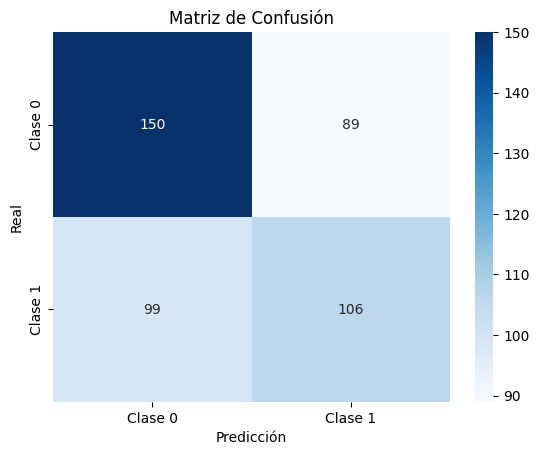

In [19]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [20]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_grid.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

                 Feature  Importance
21          STR_HEAD_B_x    0.017239
8                  REV_A    0.017187
54               Racha_A    0.016738
42        STR_GROUND_A_y    0.015979
62         Derrotas_KO_A    0.015415
..                   ...         ...
60  Victorias_Decision_A    0.011351
56        Victorias_KO_A    0.011318
63         Derrotas_KO_B    0.011079
57        Victorias_KO_B    0.011051
23          STR_HEAD_B_y    0.010958

[74 rows x 2 columns]


In [22]:
def train_xgboost_random(X_train, y_train, X_val, y_val):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1
    tscv = TimeSeriesSplit(n_splits=5)
    # Definir modelo base
    xgb = XGBClassifier(random_state=42)

    # Distribución de hiperparámetros para búsqueda aleatoria
    param_dist = {
        'n_estimators': np.arange(50, 400, 50),
        'max_depth': np.arange(3, 30, 3),
        'learning_rate': np.linspace(0.01, 0.2, 10),
        'subsample': np.linspace(0.5, 1.0, 6),
        'colsample_bytree': np.linspace(0.5, 1.0, 6),
        'gamma': np.linspace(0, 0.5, 6),
        'min_child_weight': np.arange(1, 10, 2),
        'scale_pos_weight': [1, scale_pos_weight]
    }

    # Definir la métrica de optimización como el F1-score macro
    f1_scorer = make_scorer(f1_score, average='macro')
    balanced_acc_scorer = make_scorer(balanced_accuracy_score)
    # Búsqueda con validación cruzada
    random_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        scoring=f1_scorer,
        n_iter=50,
        cv=tscv,
        n_jobs=-1,
        verbose=2,
        random_state=42
    )

    # Entrenar el modelo
    random_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", random_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = random_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))

    return random_search.best_estimator_

In [23]:
print("-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --")
best_random = train_xgboost_random(X_train,y_train,X_val,y_val)

-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros: {'subsample': np.float64(0.9), 'scale_pos_weight': np.float64(1.2990033222591362), 'n_estimators': np.int64(250), 'min_child_weight': np.int64(9), 'max_depth': np.int64(15), 'learning_rate': np.float64(0.01), 'gamma': np.float64(0.0), 'colsample_bytree': np.float64(1.0)}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.59      0.62      0.61       239
        True       0.53      0.50      0.52       205

    accuracy                           0.57       444
   macro avg       0.56      0.56      0.56       444
weighted avg       0.56      0.57      0.56       444



In [24]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = best_random.predict(X_val)
y_val_prob = best_random.predict_proba(X_val)[:,1]
print("Accuracy:", accuracy_score(y_val, y_val_pred))
f1_val = f1_score(y_val, y_val_pred)
roc_auc_val = roc_auc_score(y_val, y_val_prob)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
log_loss_val = log_loss(y_val,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")
print(confusion_matrix(y_val, y_val_pred))

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5653153153153153
F1-Score: 0.5163
AUC-ROC: 0.5855
Precisión: 0.5309
Sensibilidad: 0.5024
Log-loss: 0.6814911007061011
[[148  91]
 [102 103]]


In [76]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_random.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

           Feature  Importance
21    STR_HEAD_B_x    0.017876
55         Racha_B    0.017584
54         Racha_A    0.016752
64  Derrotas_Sub_A    0.015457
27    STR_BODY_B_y    0.015427
..             ...         ...
43  STR_GROUND_B_y    0.011773
51        Peleas_B    0.011628
1             KD_B    0.011446
41  STR_GROUND_B_x    0.011386
63   Derrotas_KO_B    0.011327

[74 rows x 2 columns]


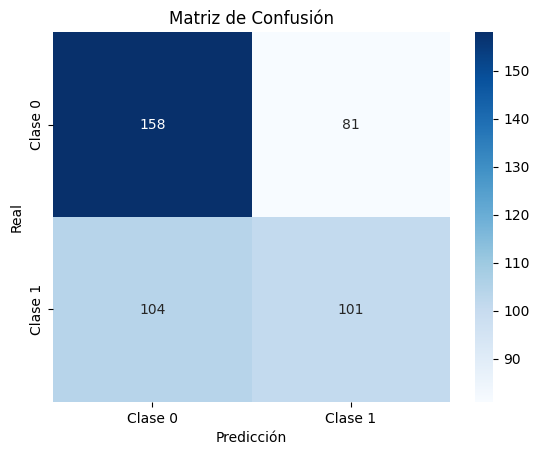

In [123]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

Tras comparar ambas estrategias, observamos que GridSearchCV tiende a encontrar combinaciones de hiperparámetros más óptimas para mejorar el F1-score, ya que evalúa exhaustivamente todas las posibles combinaciones. Sin embargo, esto conlleva un mayor coste computacional. Por otro lado, RandomizedSearchCV, aunque no explora todas las combinaciones, logra un resultado competitivo con un tiempo de ejecución significativamente menor. En este caso, si bien el modelo obtenido con RandomizedSearchCV muestra un F1-score algo inferior, ha destacado en otras métricas como el accuracy, lo que sugiere que puede ser una alternativa eficiente dependiendo de las restricciones computacionales y los objetivos del modelo.